# Cisco - Ariel University API Security Detection Challenge 2023
## Lable 1 code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

dataset_number = 1
test_type = 'label'

# Read the json and read it to a pandas dataframe object
with open(f'./datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
from urllib.parse import urlparse

# Extracts the path from the url
def url_path(row):
    parsed = urlparse(row["request.url"])
    return parsed.path

# Extracts the queries from the url
def url_query(row):
    parsed = urlparse(row["request.url"])
    return parsed.query

# Extracts the length of the url
def url_len(row):
    return len(row["request.url"])

# Checks if any of the suspected headers contains a dollar sign
def has_dollarsign(row):
    if "$" in row["request.headers.Accept-Encoding"]:
        return True
    elif "$" in row["request.headers.Sec-Fetch-Site"]:
        return True
    elif "$" in row["request.headers.Sec-Fetch-Dest"]:
        return True
    elif "$" in row["request.headers.Set-Cookie"]:
        return True
    return False

In [3]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# make new columns for the features of: url length, url path, url query, and if the suspected headers contains a dollar sign
df['url_length'] = df.apply(lambda row: url_len(row), axis=1)
df["url_path"] = df.apply(lambda row: url_path(row), axis=1)
df["url_query"] = df.apply(lambda row: url_query(row), axis=1)
df["has_dollarsign"] = df.apply(lambda row: has_dollarsign(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df.drop('request.url', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,url_length,url_path,url_query,has_dollarsign
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware,81,/static/download_txt/../../../../../../../../w...,,False
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign,48,/categories/check/name/2467,,False
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware,33,/cookielogin,,False
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign,44,/states/get/region/6117,,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware,48,/categories/check/name/2508,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware,33,/cookielogin,,False
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign,40,/orders/get/id/7668,,False
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAA

In [4]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')
    
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,url_length,url_path,url_query,has_dollarsign
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware,81,/static/download_txt/../../../../../../../../w...,,False
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign,48,/categories/check/name/2467,,False
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware,33,/cookielogin,,False
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign,44,/states/get/region/6117,,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware,48,/categories/check/name/2508,,True


In [5]:
# This is a list of the headers that we want to remove from our model
COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date', 
                    "request.headers.Sec-Fetch-Dest", 
                    "request.headers.Connection", 
                    "request.headers.Accept", 
                    "request.headers.Sec-Fetch-User",
                    "request.headers.Host",
                    "response.headers.Set-Cookie", 
                    "response.status"]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()

    # Run LabelEncoder on the chosen features
    for column in df.columns.to_list(): 
        df[column] = le.fit_transform(df[column])
    
    # Remove some columns that may be needed for the model
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Set-Cookie,request.method,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,attack_type,label,url_length,url_path,url_query,has_dollarsign
0,27,0,1,0,0,3529,0,0,0,187,0,1,1,2,1,33,1553,0,0
1,30,0,0,0,0,2052,0,0,4,181,0,1,1,0,0,16,28,0,0
2,32,0,0,0,0,4083,0,1,0,14,22,1,1,1,1,4,240,0,0
3,20,0,1,0,0,3579,0,0,4,302,0,1,1,0,0,12,1508,0,0
4,18,0,0,0,0,3980,0,0,4,181,0,1,1,3,1,16,30,0,1


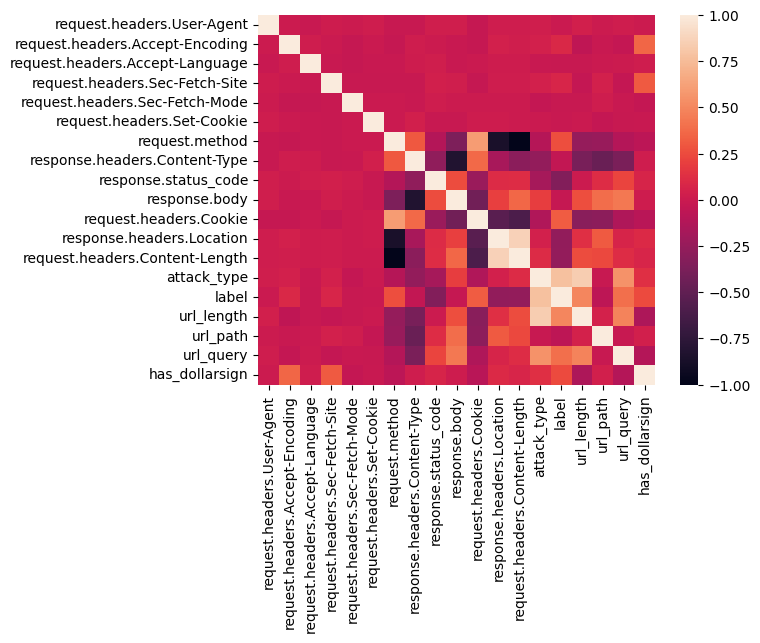

In [6]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)

In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   request.headers.User-Agent       4282 non-null   int64
 1   request.headers.Accept-Encoding  4282 non-null   int64
 2   request.headers.Accept-Language  4282 non-null   int64
 3   request.headers.Sec-Fetch-Site   4282 non-null   int64
 4   request.headers.Sec-Fetch-Mode   4282 non-null   int64
 5   request.headers.Set-Cookie       4282 non-null   int64
 6   request.method                   4282 non-null   int64
 7   response.headers.Content-Type    4282 non-null   int64
 8   response.status_code             4282 non-null   int64
 9   response.body                    4282 non-null   int64
 10  request.headers.Cookie           4282 non-null   int64
 11  response.headers.Location        4282 non-null   int64
 12  request.headers.Content-Length   4282 non-null  

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Set-Cookie', 'request.method', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Cookie', 'response.headers.Location', 'request.headers.Content-Length', 'url_length', 'url_path', 'url_query', 'has_dollarsign']


request.headers.User-Agent         int64
request.headers.Accept-Encoding    int64
request.headers.Accept-Language    int64
request.headers.Sec-Fetch-Site     int64
request.headers.Sec-Fetch-Mode     int64
request.headers.Set-Cookie         int64
request.method                     int64
response.headers.Content-Type      int64
response.status_code               int64
response.body                      int64
request.headers.Cookie             int64
response.headers.Location          int64
request.headers.Content-Length     int64
attack_type                        int64
label                              int64
url_length                         int64
url_path                           int64
url_query                          int64
has_dollarsign                     int64
dtype: object

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing RandomForest model
# X_Train and y_Train will be used for training
# X_test and y_test will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3526, 17) (3526,)
(756, 17) (756,)


Counter({1: 2264, 0: 2018})

## Model choosing and fitting

In [10]:
# We train the model on the train dataset
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))


[(0, 1662), (1, 1864)]


## Result printout

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       356
           1    1.00000   1.00000   1.00000       400

    accuracy                        1.00000       756
   macro avg    1.00000   1.00000   1.00000       756
weighted avg    1.00000   1.00000   1.00000       756



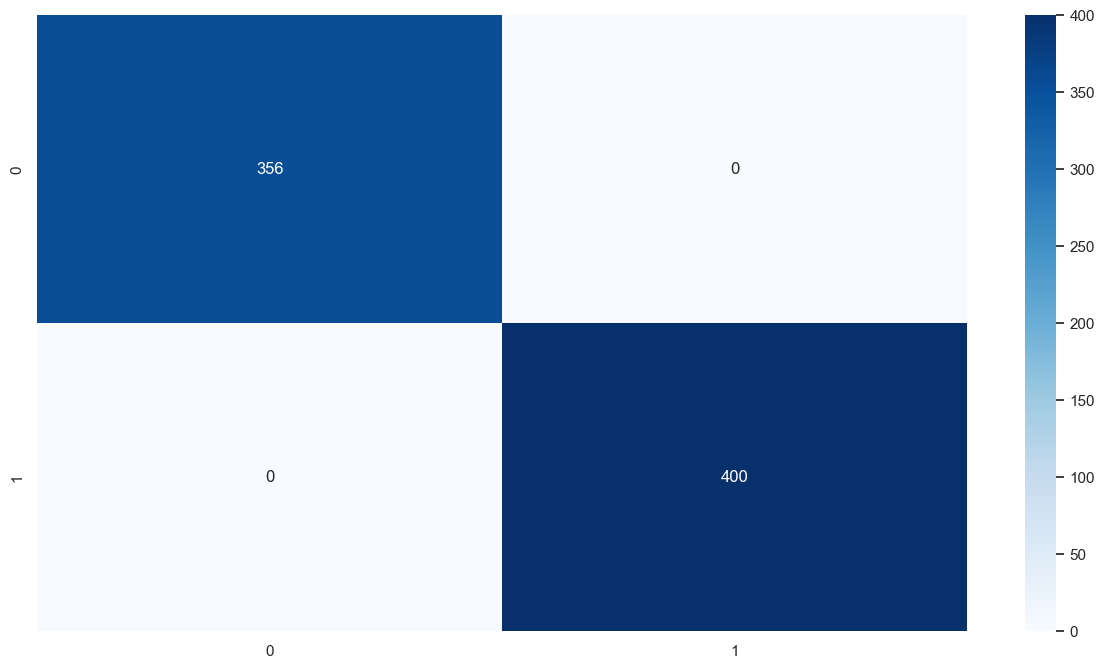

In [11]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})

predictions = clf.predict(X_test)

true_labels = y_test
clf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(clf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Read the valuation json, preprocess it and run the model 
with open(f'./datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset
test_df['url_length'] = test_df.apply(lambda row: url_len(row), axis=1)
test_df["url_path"] = test_df.apply(lambda row: url_path(row), axis=1)
test_df["url_query"] = test_df.apply(lambda row: url_query(row), axis=1)
test_df["has_dollarsign"] = test_df.apply(lambda row: has_dollarsign(row), axis=1)
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with the model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

# Save your predictions

In [13]:
# Save the preditions
enc = LabelEncoder()
np.savetxt(f'./datasets/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')